# Plots

## Util 

In [406]:
## Import statements ##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from particle import Particle
from mpl_toolkits.axes_grid.inset_locator import inset_axes

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  import sys


In [2]:
## Read in Dataframes for plots ##
# Dataframe of sorted momentums and energies for each particle
sor_df = pd.read_hdf('fast_sorted.hdf', 'lep_fast')

# Raw dataframe of values and weights with lepton cut (final state lepton pt > 0.4 GeV)
lep_df = pd.read_hdf("lep_cut_df.hdf")

In [18]:
comb_df = lep_df.merge(sor_df, left_index=True, right_on='event')

In [ ]:
# Raw GENIE dataframe of all events (10^6)
gst_df = pd.read_hdf('/Users/laurazichi/Desktop/base_generation_with_weights_9Jun_FSIFix.hdf')

In [222]:
nDict = {"-321":"$K^-$", "321":"$K^+$", "-211":"$\pi^-$", "211":"$\pi^+$", "-11":"e-", "11":"e+","22":"Photon",
         "111":"$\pi^0$", "311":"$K^+$", "2112":"Neutron", "2212":"Proton", "3112":"$\Sigma-$", "3122":"$\lambda$", 
         "3212":"$\Sigma^0$","3222":"$\Sigma^+$", "-311":"$K^?$"}

pars_all = np.array([-321, -311, -211,  -13,  -11,   11,   13,   22,  111,  211,  311,  321, 2112, 2212,
 3112, 3122, 3212,3222])

## General Plot Function

In [456]:
def plot(num, arrs, labs, Bins, units, df, wght, norm, sigma, isSub = None, ylims = None, xlims = None):
    
    if(np.any(isSub == None)):
        isSub = np.full((num, 1), False)
        ylims = np.full((num, 1), False)
        xlims = np.full((num, 1), False)
        
    axs = np.arange(1, num + 1, 1)
    fig, (axs) = plt.subplots(num, 1, figsize=(10, num * 5))

    for ax, arr, lab, bins, sub, ylim, xlim in zip (axs, arrs, labs, Bins, isSub, ylims, xlims):
        
        xlabel= '%s %s'%(lab, units)
        ylabel= ('Normalized' if norm == True else '') + 'Events / %2.2f %s '%(bins[-1]-bins[-2],units)

        ax.hist(arr, weights=df["wght"], color='red', bins = bins, label="CV", histtype = 'step', density = norm)
        ax.hist(arr, weights=df["wght_%s_p%d"%(wght,sigma)], color='blue', bins = bins,
            label="%s +%d$\sigma$"%(wght,sigma), histtype = 'step', density = norm)
        ax.hist(arr, weights=df["wght_%s_n%d"%(wght,sigma)], color='green', bins = bins,
            label="%s -%d$\sigma$"%(wght,sigma), histtype = 'step', density = norm)
        
        if(sub):
            subplot(ax, arr, df, bins, wght, sigma, norm, ylim, xlim)
        
        ax.legend(fontsize = 14)
        ax.set_xlabel(xlabel, fontsize = 18)
        ax.set_ylabel(ylabel, fontsize = 18)
    

In [455]:
def subplot(ax, arr, df, bins, wght, sigma, norm, ylim = 6000, xlims = np.array([0.2, 0.4]), hght = 2, wdt = 2.5):
     
    inset_ax = inset_axes(ax, loc = 'center', height = hght, width = wdt)
    inset_ax.hist(arr, weights=df["wght"], color='red', bins = bins, label="CV", histtype = 'step', density = norm)
    inset_ax.hist(arr, weights=df["wght_%s_p%d"%(wght,sigma)], color='blue', bins = bins, 
        label="%s +%d$\sigma$"%(wght,sigma), histtype = 'step', density = norm)
    inset_ax.hist(arr, weights=df["wght_%s_n%d"%(wght,sigma)], color='green', bins = bins, 
        label="%s -%d$\sigma$"%(wght,sigma), histtype = 'step', density = norm)
    
    inset_ax.set_xlim(xlims[0], xlims[1])
        
    inset_ax.set_ylim(0, ylim)


## Pt Plots
pt Leading particles, pt Leading particles above and below an energy threshold

In [191]:
def plot_pt_lead(df, pars, Bins, wght, par_dic = nDict, units = "GeV/c", sigma = 1, norm = False):
    '''Plot Pt of leading particle for each event in df for all particles in pars array.'''
    
    plots = []
    labls = []
    
    for par in pars:
        plots.append(np.sqrt(df['pxf %s l'%(par)]**2 + df['pyf %s l'%(par)]**2))
        labls.append('$p_t$, Leading %s'%(nDict.get(str(par))))

    num = np.size(pars)
    plot(num, plots, labls, Bins, units, df, wght, norm, sigma)

In [350]:
def plot_pt_thresh(df, pars, Bins, wght, par_dic = nDict, thresh = 0.06, units = "GeV/c", sigma = 1, norm = False):
    '''Plot pt for all particles in pars above and below a designated threshold for every event.'''
    plots = []
    labls = []
    
    for par in pars:
        
        p = Particle.from_pdgid(par)
        arr_temp = df['Ef %s l'%(par)].to_numpy()
        arr_temp[arr_temp == 0] = np.nan
        
        plots.append(np.where(arr_temp - (p.mass/1000) > thresh, np.sqrt(df['pxf %s l'%(par)]**2 + df['pyf %s l'%(par)]**2), np.nan))
        plots.append(np.where(arr_temp - (p.mass/1000) < thresh, np.sqrt(df['pxf %s l'%(par)]**2 + df['pyf %s l'%(par)]**2), np.nan))
        
        labls.append('$p_t$, Leading %s KE > %s'%(nDict.get(str(par)), thresh))
        labls.append('$p_t$, Leading %s KE < %s'%(nDict.get(str(par)), thresh))

    num = np.size(pars)*2
    plot(num, plots, labls, Bins, units, df, wght, norm, sigma)
    

## Energy Plots
KE/Energy of leading particles for all events. KE/Energy of all particles in an event for all events. KE/Energy for all particles per event. 

In [363]:
def plot_engy_ledng(df, pars, Bins, wght, par_dic = nDict, units = "GeV/c", sigma = 1, norm = False):
    '''Plot the energy/KE (strange baryons, n, p) for the leading particle for each particle in pars for every event'''
    plots = []
    labls = []
    
    for par in pars:
        
        p = Particle.from_pdgid(par)
        arr_temp = df['Ef %s l'%(par)].to_numpy()
        arr_temp[arr_temp == 0] = np.nan
            
        if (par == 2112 or par == 2212 or par == 3112 or par == 3122 or par == 3212 or par == 3222):
            mass = p.mass/1000
            lab = 'KE'
        else:
            mass = 0
            lab = 'Energy'
                
        plots.append(np.nan_to_num(arr_temp - mass))
        labls.append('%s, Leading %s'%(lab, nDict.get(str(par))))
    
    num = np.size(pars)
    plot(num, plots, labls, Bins, units, df, wght, norm, sigma)

In [451]:
def plot_engy_sum(df, pars, Bins, wght, labels, par_dic = nDict, units = "GeV/c", sigma = 1, norm = False, isSub = None, ylims = None, xlims = None):
    '''Plot the sum of the energy of KE (strange baryons, n, p) for all particles for each in pars for every event'''
    plots = []
    labls = labels

    for par in pars:
        arr = np.zeros(np.shape(sor_df)[0])
        for p in par:
            arr = arr + df['cal %s'%(p)]
                
        plots.append(arr)
    
    num = np.size(pars)
    plot(num, plots, labls, Bins, units, df, wght, norm, sigma, isSub, ylims, xlims)

## Code checks

In [ ]:
### check events ##
wght = "FrCEx_pi"
sigma = 1
Bins = np.array([np.arange(0, 1.0, 0.05), np.arange(0, 1.0, 0.05), np.arange(0, 1, 0.05), np.arange(0, 2.0, 0.05)])
arr_plot = np.array([df_new['Ef 211 sum'], df_new['Ef -211 sum'], df_new['Ef 111 sum'], 
                     (df_new['Ef 211 sum'] + df_new['Ef -211 sum'] + df_new['Ef 111 sum'])])

for arr, bins in zip(arr_plot, Bins):
    events, bins = np.histogram(arr, bins = bins, weights=lep_df["wght"])
    print(round(np.sum(events), ndigits = 3))
    events, bins = np.histogram(arr, bins = bins, weights=lep_df["wght_%s_p%d"%(wght,sigma)])
    print(round(np.sum(events), ndigits = 3))
    events, bins = np.histogram(arr, bins = bins, weights=lep_df["wght_%s_n%d"%(wght,sigma)])
    print(round(np.sum(events), ndigits = 3))
    

## FrCeX 
### FrCEx_N & FrCEx_pi

None


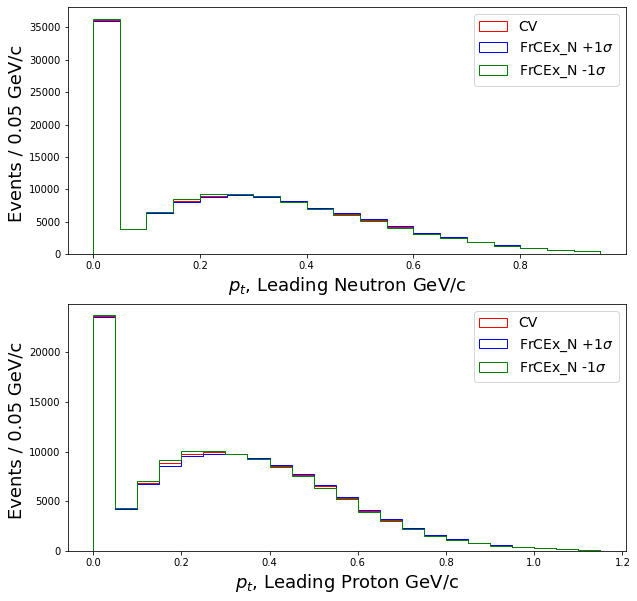

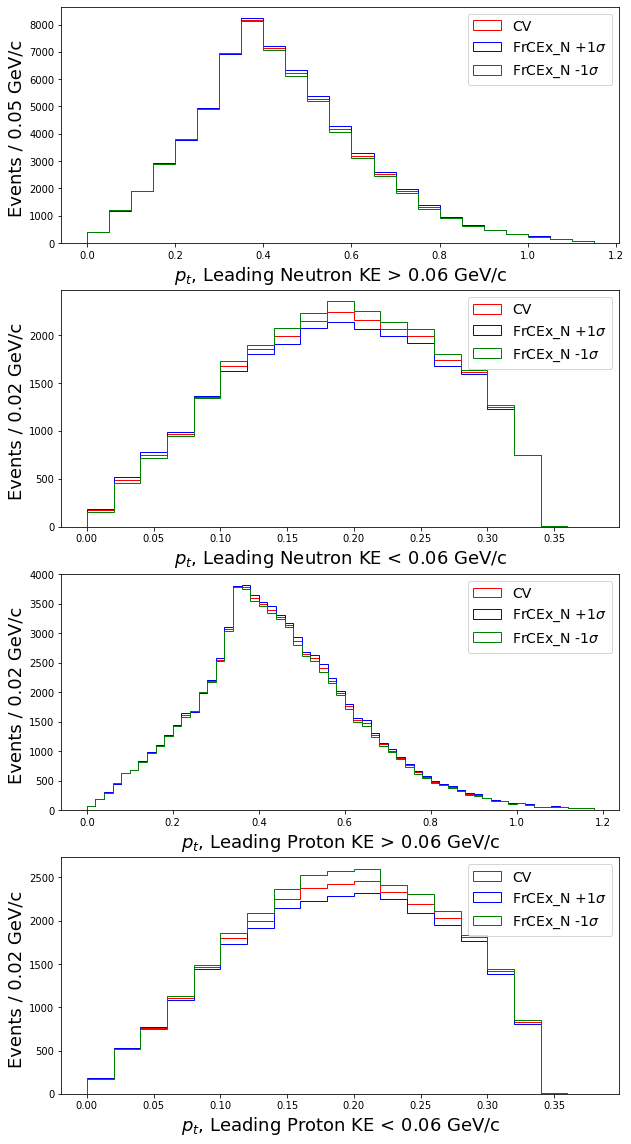

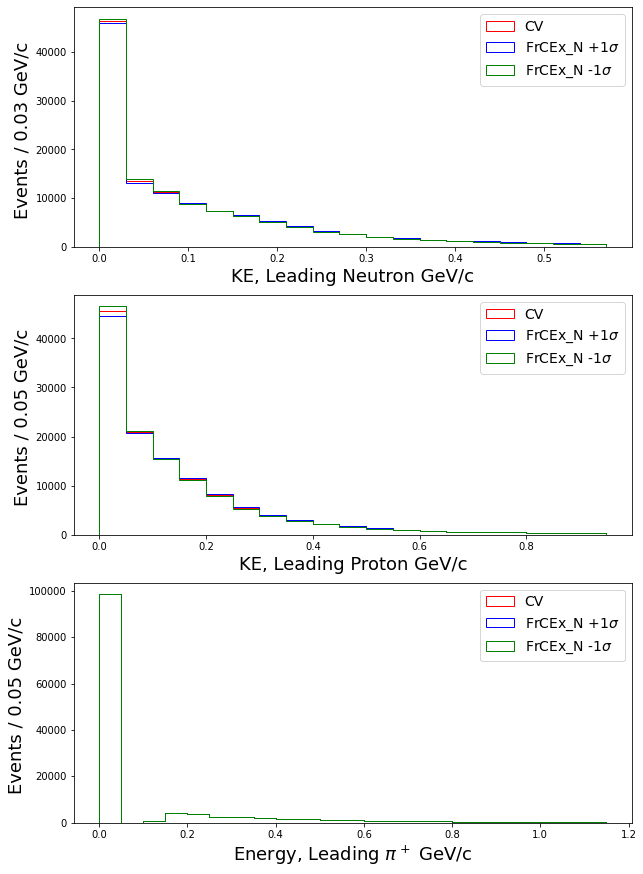

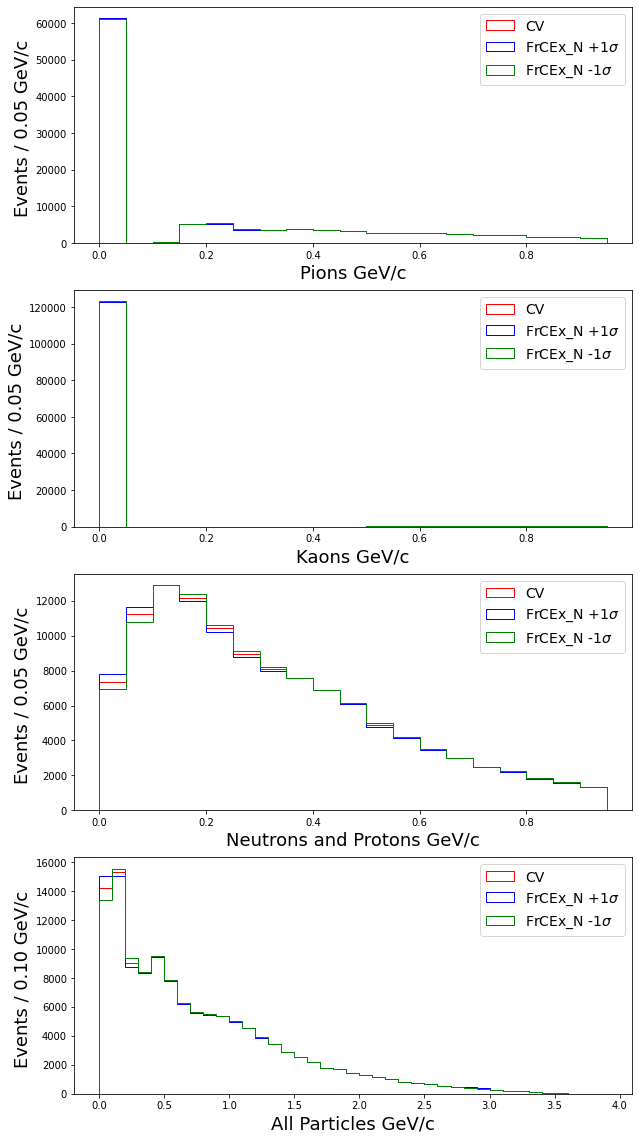

In [424]:
#################################
########### FrCEx_N #############
#################################
# Pt of Leading proton and nuetron
Bins = np.array([np.arange(0,1,0.05), np.arange(0,1.2,0.05)], dtype = 'object')
plot_pt_lead(comb_df, np.array([2112, 2212]), Bins, 'FrCEx_N')

# Pt of Leading proton and nuetron above and below KE cut of 0.06 GeV
Bins = np.array([np.arange(0,1.2,0.05), np.arange(0,0.4,0.02), np.arange(0,1.2,0.02), np.arange(0,0.4,0.02)], dtype = 'object')
plot_pt_thresh(comb_df, np.array([2112, 2212]), Bins, 'FrCEx_N')

# KE of leading neutron and proton, energy of leading pion+
Bins = np.array([np.arange(0,0.6,0.03), np.arange(0,1.0,0.05), np.arange(0,1.2,0.05)], dtype = 'object')
KE_leading = np.array([2112, 2212, 211])
plot_engy_ledng(comb_df, KE_leading, Bins, 'FrCEx_N')

# Energy sum: pions, kaons, protons and neutrons (KE sum), all particles
Bins = np.array([np.arange(0,1.0,0.05), np.arange(0,1.0,0.05), np.arange(0,1.0,0.05), np.arange(0, 4, 0.1)], dtype = 'object')
KE_sum = np.array([[211, -211, 111], [-321, 321, 311, -311], [2112, 2212], pars_all], dtype = 'object')
labels = np.array(['Pions', 'Kaons', 'Neutrons and Protons', 'All Particles'])
plot_engy_sum(comb_df, KE_sum, Bins, 'FrCEx_N', labels)

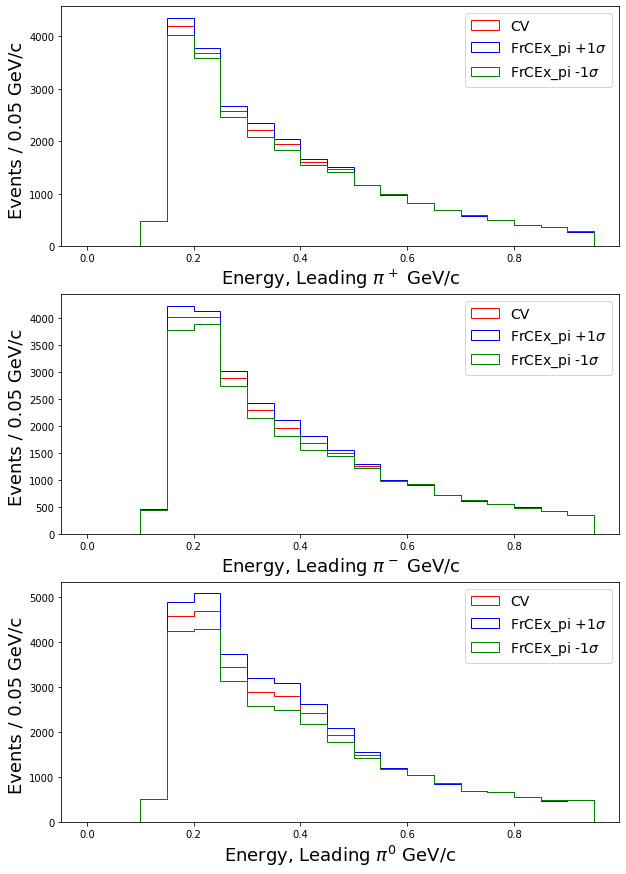

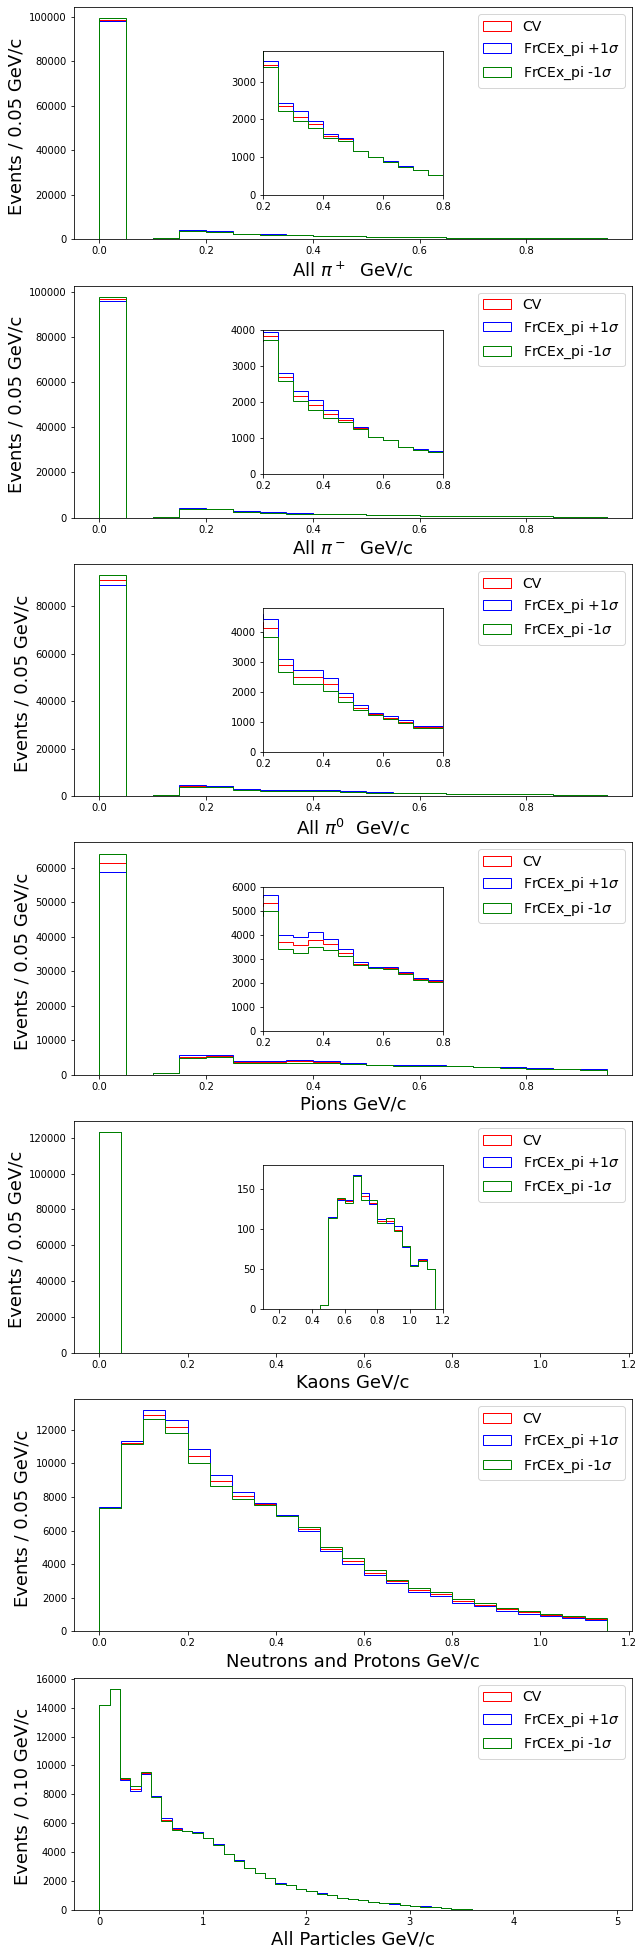

In [462]:
#################################
########### FrCEx_pi #############
#################################

# Pt of Leading pion+, pion-, pion_0 
Bins = np.array([np.arange(0.09, 1.0, 0.03), np.arange(0.09, 1.0, 0.03), np.arange(0.09, 1.0, 0.03)], dtype = 'object')
#plot_pt_lead(comb_df, np.array([211, -211, 111]), Bins, 'FrCEx_pi')

# Pt of Leading pion+, pion-, pion_0, above and below KE cut of 0.06 GeV
Bins = np.array([np.arange(0, 1.0, 0.03), np.arange(0, 0.5, 0.02), np.arange(0, 1.0, 0.03), 
                 np.arange(0, 0.4, 0.03), np.arange(0, 1.0, 0.03), np.arange(0, 1.5, 0.32)], dtype = 'object')
#plot_pt_thresh(comb_df, np.array([211, -211, 111]), Bins, 'FrCEx_pi')

# Energy leading pion+, pion-, pion_0
Bins = np.array([np.arange(0.00001,1,0.05), np.arange(0.00001,1,0.05), np.arange(0.00001,1,0.05)], dtype = 'object')
KE_leading = np.array([211, -211, 111])
plot_engy_ledng(comb_df, KE_leading, Bins, 'FrCEx_pi')

# Energy sum: pion+, pion-, pion_0, pions, kaons, all particles
Bins = np.array([np.arange(0,1,0.05), np.arange(0,1,0.05), np.arange(0,1,0.05), np.arange(0,1,0.05), 
                 np.arange(0,1.2,0.05), np.arange(0,1.2,0.05), np.arange(0, 5, 0.1)], dtype = 'object')

KE_sum = np.array([[211], [-211], [111], [211, -211, 111], [-321, 321, 311], [2112, 2212], pars_all], dtype = 'object')
labels = np.array(['All $\pi^+$ ','All $\pi^-$ ','All $\pi^0$ ', 'Pions', 'Kaons', 'Neutrons and Protons', 'All Particles'])
isSub = np.array([True, True, True, True, True, False, False])
ylims = np.array([3800, 4000, 4800, 6000, 180, None, None], dtype = 'object')
xlims = np.array([[0.2, 0.8], [0.2, 0.8], [0.2, 0.8], [0.2, 0.8], [0.1, 1.2], None, None], dtype = 'object')
plot_engy_sum(comb_df, KE_sum, Bins, 'FrCEx_pi', labels, isSub = isSub, ylims = ylims, xlims = xlims)


## 